In [4]:
from data_utils import load_data, notnan_indices, downsample_signal, moving_average

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data_dir = "./data"
virgo_file = "VIRGO_Level1.txt"
results_dir = os.path.join(data_dir, "analysis")

data = load_data(os.path.join(data_dir, virgo_file))

t = data["timestamp"]  # Time in mission days
# t = data["timestamp"].apply(mission_day_to_year)  # Uncomment for time measured in years
pmo_a = data["pmo6v_a"]
pmo_b = data["pmo6v_b"]
temp = data["temperature"]
data.sample(15, random_state=2)

,timestamp,pmo6v_a,pmo6v_b,temperature
916133,707.2037,1364.124,NaN,27.612
4540366,3224.0322,1360.755,NaN,29.833
1184820,893.7919,1363.791,NaN,26.496
1652927,1218.8662,1363.623,NaN,26.422
6541184,4613.4893,NaN,NaN,29.463
6169960,4355.6948,1360.001,NaN,31.748
9447604,6631.8364,1359.868,NaN,29.349
10494042,7358.5293,1359.368,NaN,29.713
11214199,7858.6382,1358.931,NaN,27.109
7101944,5002.9058,1359.604,NaN,28.829


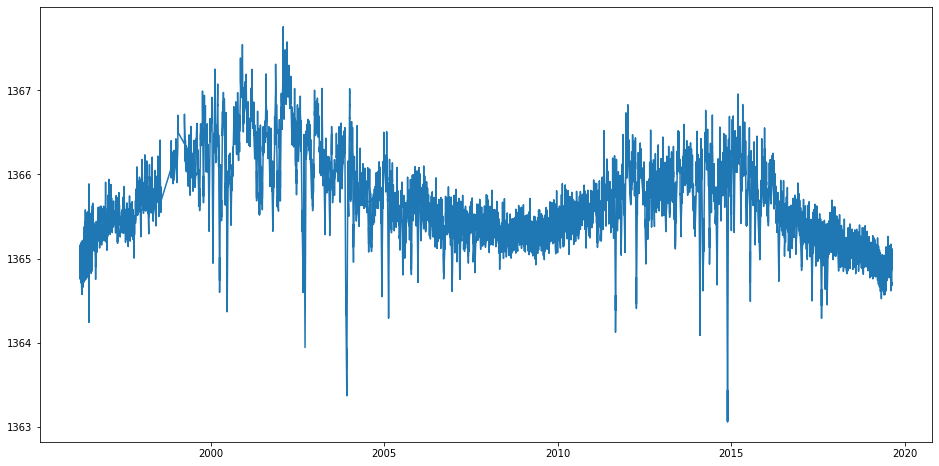

In [119]:
t_b = t[notnan_indices(pmo_b)]
x_b = pmo_b[notnan_indices(pmo_b)]

plt.figure(1, figsize=(16, 8))
plt.plot(t_b, x_b)
plt.savefig(os.path.join(results_dir, "pmo6v_b_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

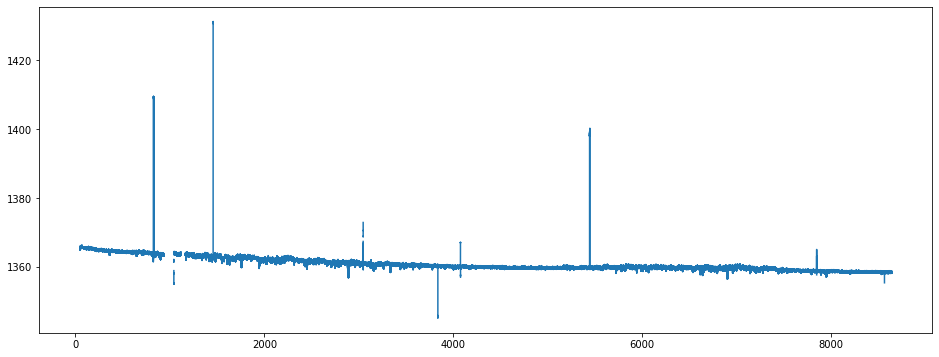

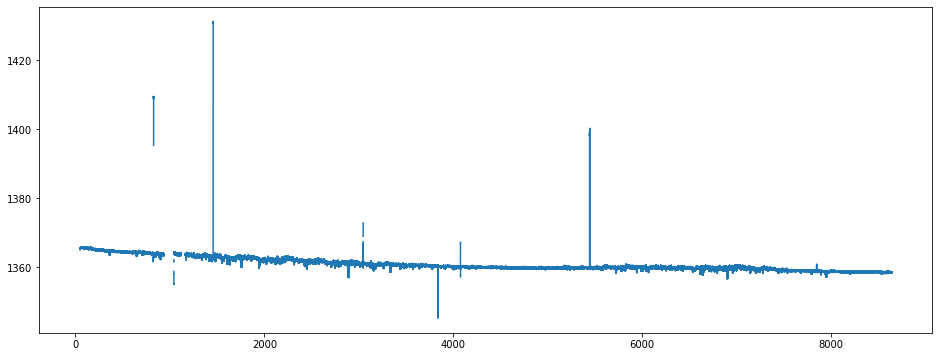

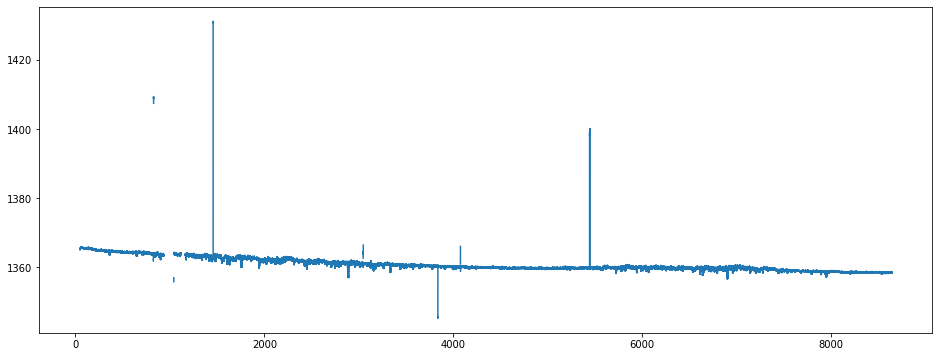

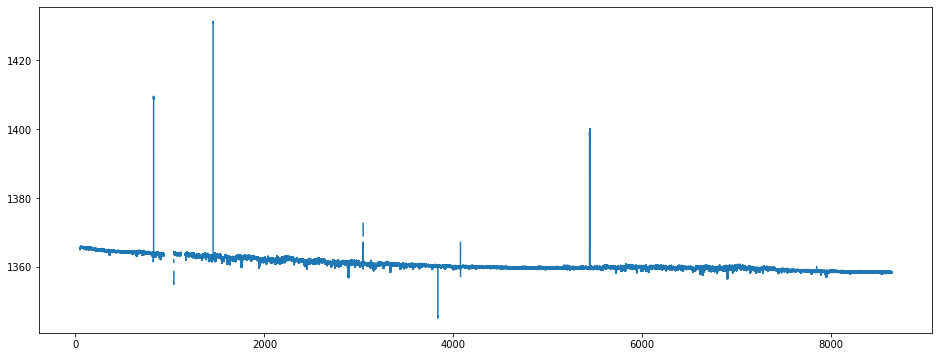

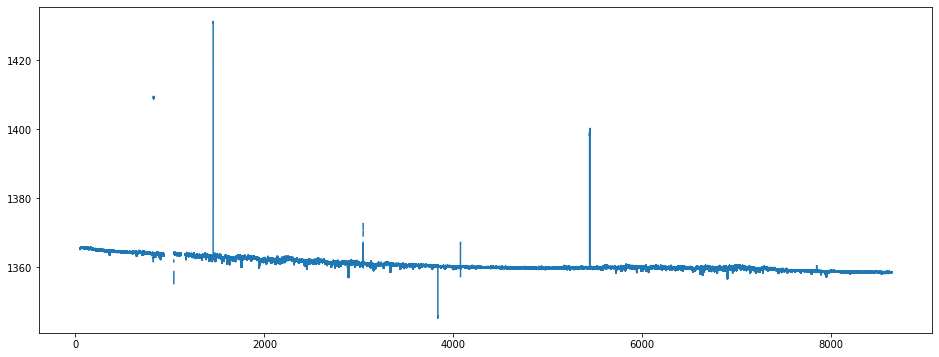

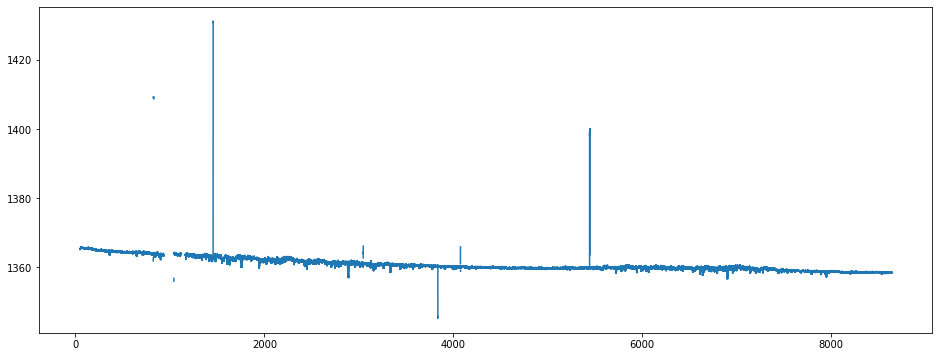

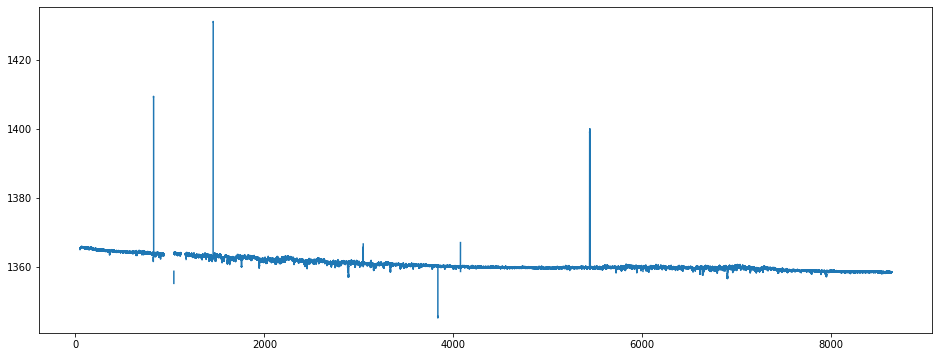

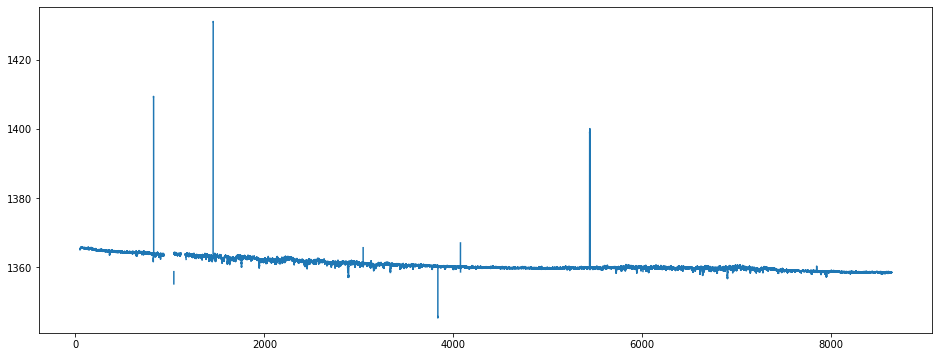

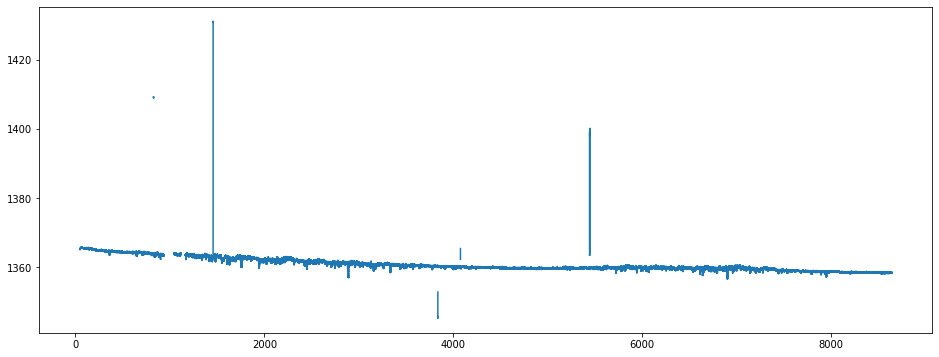

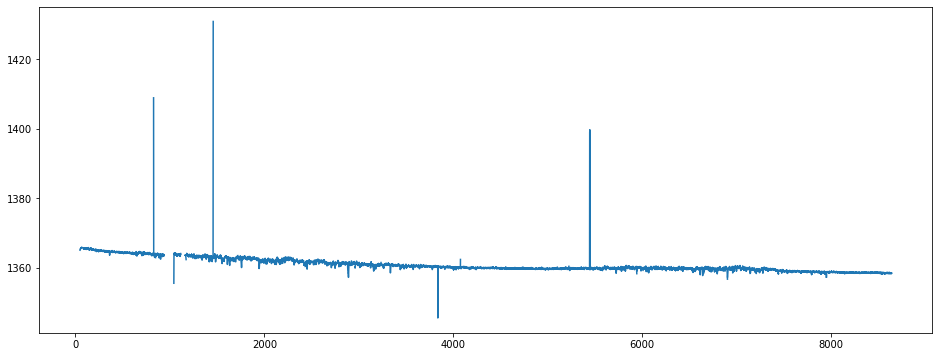

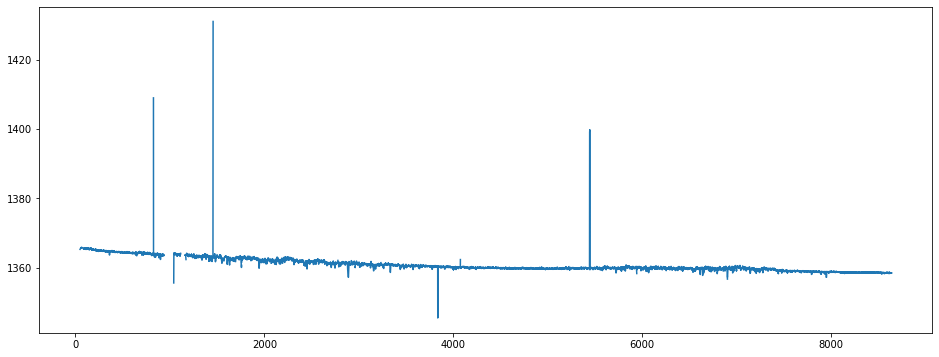

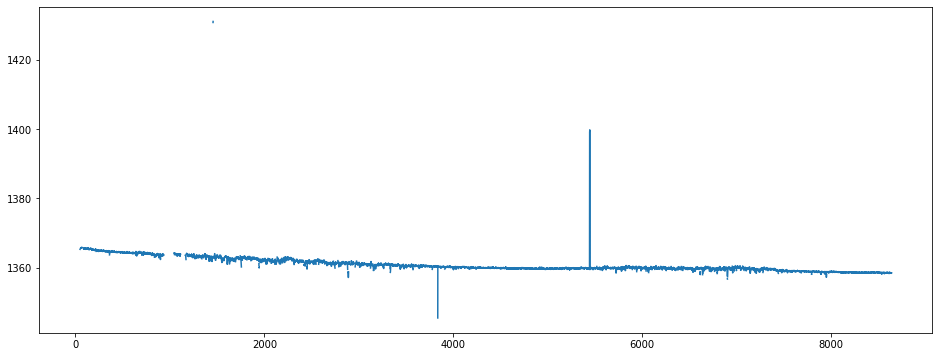

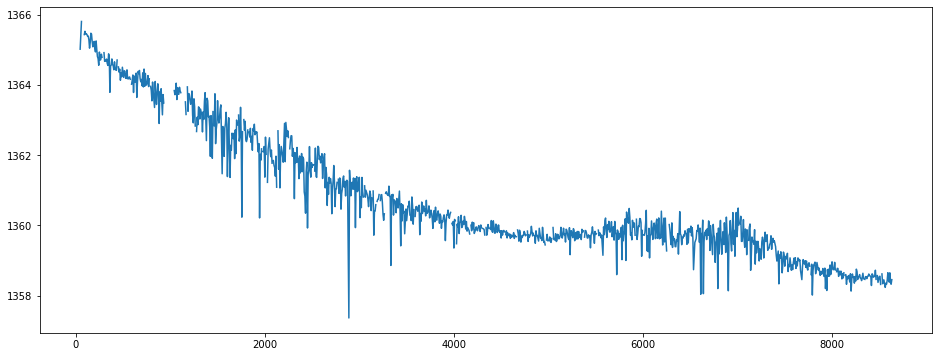

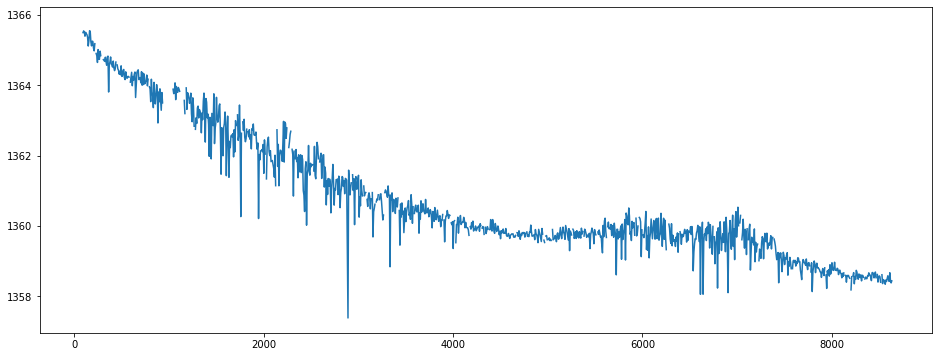

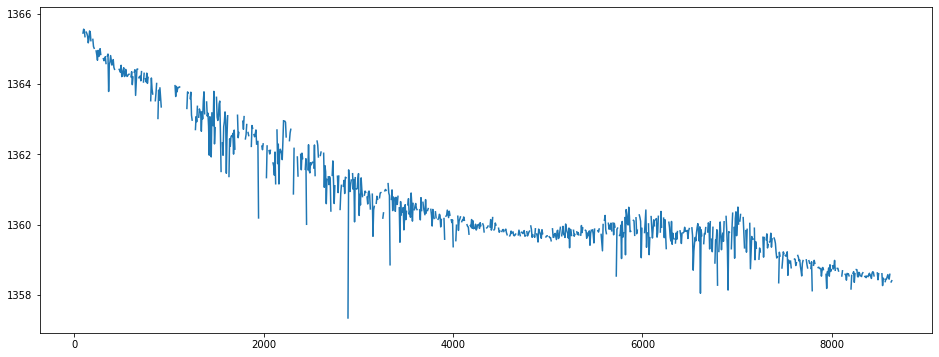

In [22]:
for p in range(0, 5):
    for W in [1, 10, 100]:
        T = 10 ** p
        x_a = downsample_signal(moving_average(pmo_a, W), T)
        t_a = downsample_signal(t, T)

        plt.figure(2, figsize=(16, 6))
        plt.plot(t_a, x_a)
        plt.savefig(os.path.join(results_dir, "pmo6v_a_raw_W{}_T{}.png".format(W, T)), bbox_inches="tight", quality=100, dpi=200)
        plt.show()
        
T = 100
W = 1
x_a = downsample_signal(moving_average(pmo_a, W), T)
t_a = downsample_signal(t, T)

plt.figure(2, figsize=(16, 6))
plt.scatter(t_a, x_a, marker="x")
plt.savefig(os.path.join(results_dir, "pmo6v_a_raw_W{}_T{}_scatter.png".format(W, T)), bbox_inches="tight", quality=100, dpi=200)
plt.show()

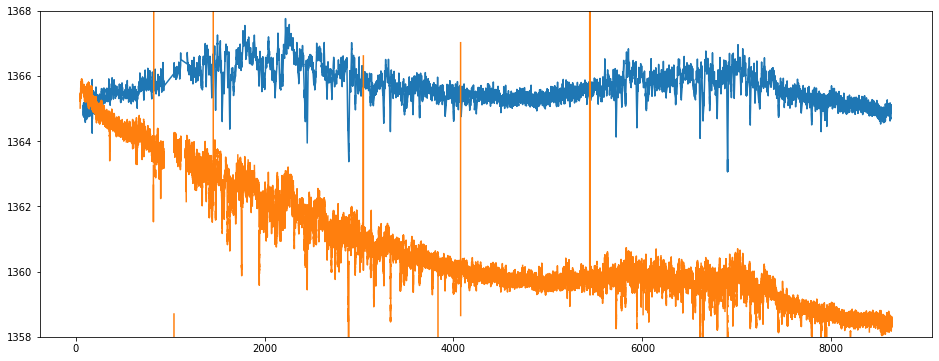

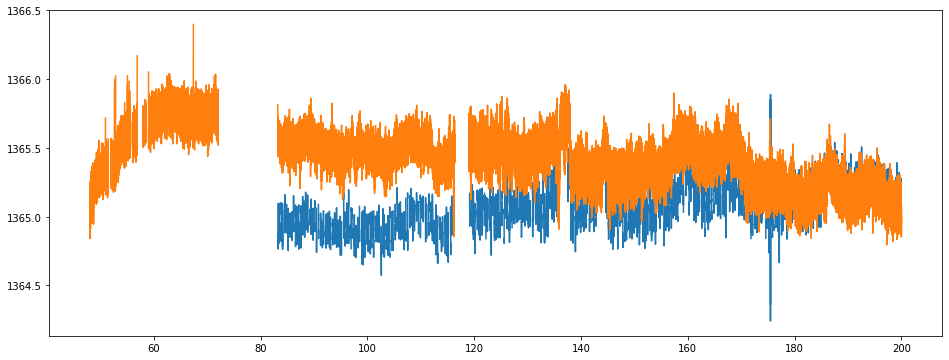

In [46]:
plt.figure(3, figsize=(16, 6))
plt.plot(t_b, x_b, t_a, x_a)
plt.savefig(os.path.join(results_dir, "pmo6v_a_b_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.ylim(1358, 1368)
plt.savefig(os.path.join(results_dir, "pmo6v_a_b_lim_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

T_early = 200
t_e = t[t <= T_early]
x_a_e = pmo_a[t <= T_early]
x_b_e = pmo_b[t <= T_early]

plt.figure(4, figsize=(16, 6))
plt.plot(t_e, x_b_e, t_e, x_a_e)
plt.savefig(os.path.join(results_dir, "pmo6v_early_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

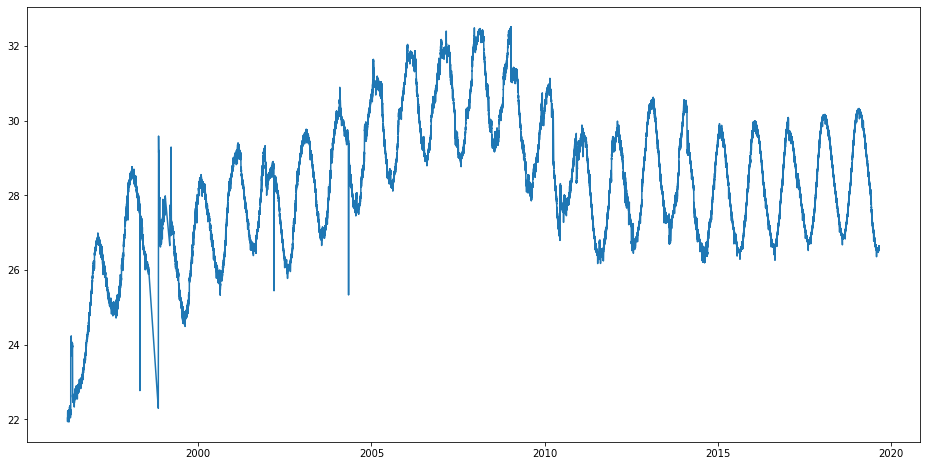

In [118]:
t_t = t[notnan_indices(temp)]
x_t = temp[notnan_indices(temp)]

plt.figure(4, figsize=(16, 8))
plt.plot(t_t, x_t)
plt.savefig(os.path.join(results_dir, "temp_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

6.950051942186089


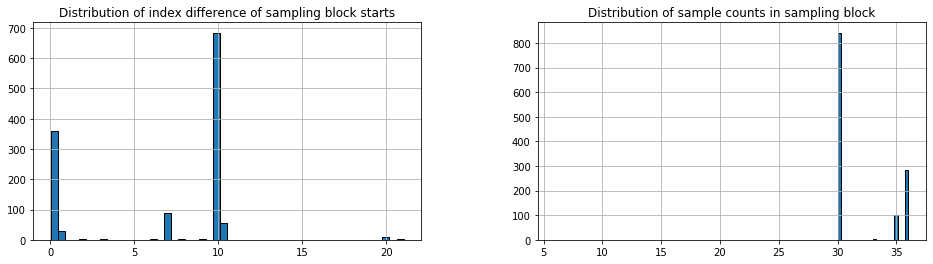

In [86]:
sampling_intervals = []
sampling = False

for index, row in data.iterrows():    
    if not np.isnan(row[2]) and not sampling:
        sampling = True
        start = index
        # print("sampling start", start)
        
    elif np.isnan(row[2]) and sampling and (index - start) > 5:
        sampling = False
        end = index
        # print("sampling end", end)
        sampling_intervals.append((start, end))

# print(sampling_intervals)

counts = np.array([interval[1] - interval[0] for interval in sampling_intervals])
starts = np.array([interval[0] for interval in sampling_intervals])

diffs = starts[1:] - starts[:-1]
diffs = diffs / (24 * 60)
print(diffs.mean())
diffs = diffs[diffs < 30]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
pd.DataFrame(diffs).hist(bins=50, ax=ax[0], ec="black")
ax[0].set_title("Distribution of index difference of sampling block starts")

pd.DataFrame(counts).hist(bins=100, ax=ax[1], ec="black")
ax[1].set_title("Distribution of sample counts in sampling block")

plt.show()
fig.savefig(os.path.join(results_dir, "pmo6v_b_diffs_counts_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)

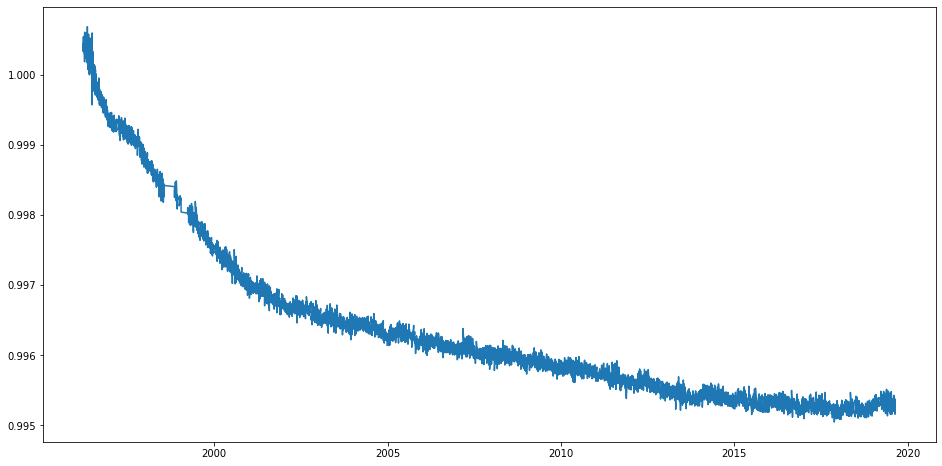

In [117]:
data_nn = data[["timestamp", "pmo6v_a", "pmo6v_b"]].dropna()
t_nn = data_nn["timestamp"]
x_a_nn = data_nn["pmo6v_a"]
x_b_nn = data_nn["pmo6v_b"]
ratio_a_b = x_a_nn/x_b_nn

plt.figure(5, figsize=(16, 8))
plt.plot(t_nn, ratio_a_b)
plt.savefig(os.path.join(results_dir, "ratio_a_b_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

outliers 30835


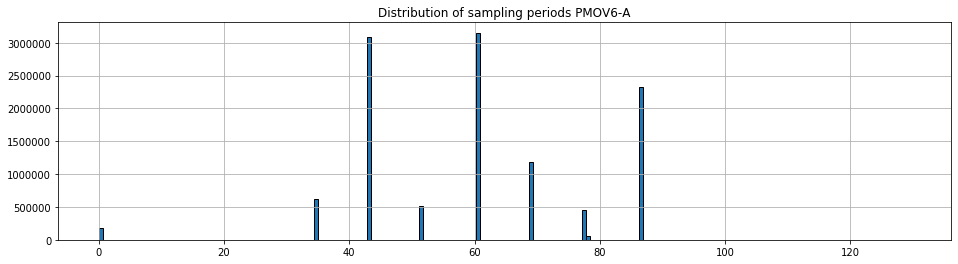

In [155]:
data_nn_a = data[["timestamp", "pmo6v_a"]].dropna()
t_nn_a = data_nn_a["timestamp"].values

sampling_diffs = t_nn_a[1:] - t_nn_a[:-1]
sampling_diffs = sampling_diffs * 24 * 3600
print("outliers", (sampling_diffs >= 150).sum())
sampling_diffs = sampling_diffs[sampling_diffs < 150]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
pd.DataFrame(sampling_diffs).hist(bins=200, ax=ax, ec="black")
ax.set_title("Distribution of sampling periods PMOV6-A")
plt.savefig(os.path.join(results_dir, "sampling_distribution_a.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

outliers 1229


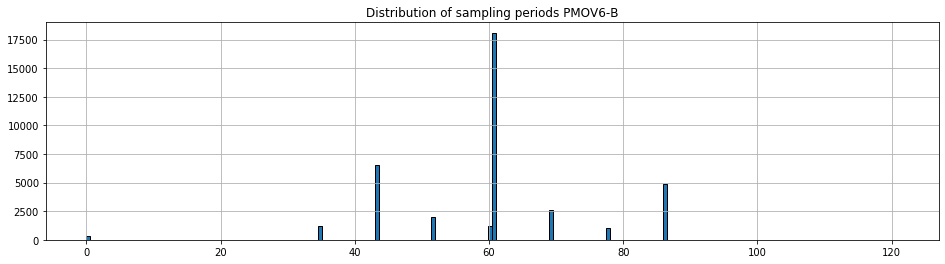

In [156]:
data_nn_b = data[["timestamp", "pmo6v_b"]].dropna()
t_nn_b = data_nn_b["timestamp"].values

sampling_diffs = t_nn_b[1:] - t_nn_b[:-1]
sampling_diffs = sampling_diffs * 24 * 3600
print("outliers", (sampling_diffs >= 3600).sum())
sampling_diffs = sampling_diffs[sampling_diffs < 3600]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
pd.DataFrame(sampling_diffs).hist(bins=200, ax=ax, ec="black")
ax.set_title("Distribution of sampling periods PMOV6-B")
plt.savefig(os.path.join(results_dir, "sampling_distribution_b.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

outliers 20


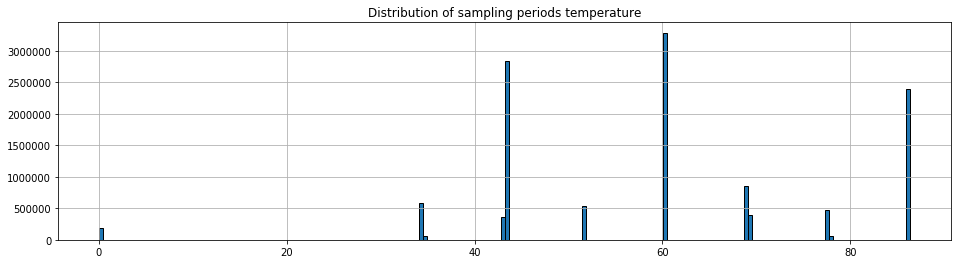

In [157]:
data_nn_t = data[["timestamp", "temperature"]].dropna()
t_nn_t = data_nn_t["timestamp"].values

sampling_diffs = t_nn_t[1:] - t_nn_t[:-1]
sampling_diffs = sampling_diffs * 24 * 3600
print("outliers", (sampling_diffs >= 3600).sum())
sampling_diffs = sampling_diffs[sampling_diffs < 3600]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
pd.DataFrame(sampling_diffs).hist(bins=200, ax=ax, ec="black")
ax.set_title("Distribution of sampling periods temperature")
plt.savefig(os.path.join(results_dir, "sampling_distribution_t.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()